<a href="https://colab.research.google.com/github/LaisFSGomes/Classificacao-de-Sentimentos-com-CNN/blob/main/Classifica%C3%A7%C3%A3o_de_Sentimentos_usando_Redes_Neurais_Convolucionais.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Etapa 1: Importação das bibliotecas

In [1]:
import numpy as np              #lib cienfífica do python
import math                     #para ter-mos acesso a recursosd e calculos matemáticos
import re                       #porque vamos trabalhar com expressões regulares
import pandas as pd             #para carregar a base de dados
from bs4 import BeautifulSoup   #é usada pra se fazer preprocessamento em textos
from google.colab import drive  #para termos acesso de recursos do google drive
import zipfile                  #para poder descompactar arquivos .zip
import seaborn as sns           #para visualização de gráficos
import spacy as sp              #é uma lib de processamento de linguagem natural que será usada para fazer o preprocessamento em alguns textos
import string                   #vai ser usada para o pré processamento dos textos
import random                   #para números aleatórios
import matplotlib.pyplot as plt #usada para gerar gráficos
from sklearn.model_selection import train_test_split

In [2]:
%tensorflow_version 2.x
import tensorflow as tf
tf.__version__

'2.6.0'

In [3]:
from tensorflow.keras import layers   #para ter-mos acesso as camadas
import tensorflow_datasets as tfds    

# **Etapa 2: Pré-processamento dos dos dados**

## **Carregamento Dos Arquivos**

In [4]:
drive.mount("/content/drive")

Mounted at /content/drive


In [5]:
path = '/content/drive/MyDrive/Database/trainingandtestdata.zip'
zip_object = zipfile.ZipFile(file = path, mode='r') #r pq será feito uma leitura
zip_object.extractall('./')
zip_object.close()

In [6]:
cols = ['sentiment', 'id', 'date', 'query', 'user', 'text']

In [7]:
train_data = pd.read_csv('/content/trainingandtestdata/train.csv', header= None, names= cols, engine='python', encoding='latin1')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


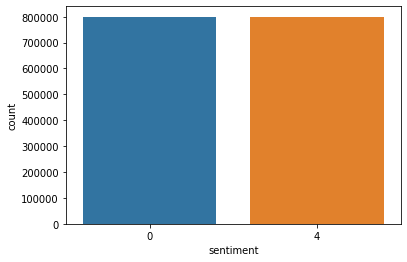

In [8]:
sns.countplot(train_data.sentiment);

In [9]:
test_data = pd.read_csv("/content/trainingandtestdata/test.csv", header=None, names=cols, engine="python", encoding="latin1")

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


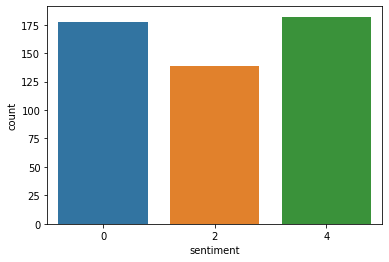

In [10]:
sns.countplot(test_data.sentiment);

## **Limpeza**

In [11]:
data = train_data #para trabalhar com essa variável

In [12]:
data.drop(['id', 'date', 'query', 'user'], axis=1, inplace=True);

In [13]:
data.head()

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [14]:
X = data.iloc[:, 1].values

In [15]:
X.shape
type(X)

numpy.ndarray

In [16]:
y = data.iloc[:, 0].values

In [17]:
X.shape
y

array([0, 0, 0, ..., 4, 4, 4])

In [18]:
X, _, y, _ = train_test_split(X, y, test_size = 0.85, stratify = y) #vamos returar 85% da base de dados. X e y representam a porção de treinamento e _ e _ a porção de teste.
#esse estratify vai fazer com que seja dividido de forma igual as classes, não fique mais demais de um lado e menos no outro

In [19]:
X.shape

(240000,)

In [20]:
y.shape

(240000,)

In [66]:
unique, counts = np.unique(y, return_counts= True)
unique, counts

(array([0, 4]), array([120000, 120000]))

In [67]:
nlp = sp.load('en')
nlp

In [69]:
stop_words = sp.lang.en.STOP_WORDS #lista das palavras que podem ser removidas

In [159]:
def clean_tweets(tweet):
  tweet = BeautifulSoup(tweet, 'lxml').get_text()
  tweet = re.sub(r"@[A-Za-z0-9]+", ' ', tweet) #retirar o @user
  tweet = re.sub(r"https?://[A-Za-z0-9./]+", " ", tweet) #retirar a url
  tweet = re.sub(r"[^a-zA-Z.!?]", ' ', tweet) #retirar os numeros
  tweet = re.sub(r" +", ' ', tweet) #remover os excessos de espaços

  tweet = tweet.lower() #conversão para minúsculo
  document = nlp(tweet)

  words = []
  for token in document:
    words.append(token.text)

    #remoção das stop_words e pontuações
  words = [word for word in words if word not in stop_words and word not in string.punctuation]
  words = ' '.join([str(element) for element in words])
  return words

In [162]:
text = "@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  2 You shoulda got David Carr of Third Day to do it. ;D"

In [164]:
text = clean_tweets(text)
text

'awww s bummer shoulda got david carr day d'

In [165]:
data_clean = [clean_tweets(tweet) for tweet in X]

In [168]:
for _ in range(10):
  print(data_clean[random.randint(0, len(data_clean) - 1)])

  forget traditions try lamps tin foil reflectors led flashlights computer monitors weird lighting
got eating awesome chicken salad mmm ... clean little going work sad
going twitter hiatus futher notice .. let suffering begin
  ahah pie
  sweet ll let wesley know
finalizing menu father s day dinner dad excited
  manage laugh wiped day losing job funny
  s wrong going chicago
  amaizing bad video asot
home hearing weird noises oooooo scary


In [174]:
data_labels = y

array([1, 0, 0, ..., 1, 1, 1])

In [176]:
data_labels[data_labels == 4] = 1

## **Tokenização (Transformar as letras em números)**

In [208]:
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(data_clean, target_vocab_size=2**16) 

In [209]:
print(tokenizer.subwords)

['  ', 's_', 'm_', 't_', ' ... ', 'good_', ' .. ', 'like_', 'got_', 'day_', 'going_', 'nt_', 'love_', 'don_', 'u_', ' ...', 'work_', 'today_', 'know_', 'time_', 'new_', 'll_', 'think_', 'want_', 'oh_', 'need_', 'lol_', 'thanks_', 'hope_', 'night_', 've_', 'home_', 'miss_', 'great_', 'd_', 'feel_', ' .... ', 'wish_', 'twitter_', 'morning_', 'day', 'lol', 'na_', 'gon_', 'getting_', 'today', 'happy_', 'bad_', 'watching_', 'haha_', 'sorry_', 'tomorrow_', 'didn_', 'way_', 'come_', 'nice_', ' ..', 'sleep_', 'fun_', 'sad_', 'yeah_', 'wait_', 'work', 'hate_', 'n_', 'hey_', 'right_', 'people_', 'having_', 'better_', 'little_', 'school_', 'bed_', 'yes_', 'y_', 'long_', 'tonight_', 'wanna_', 'best_', 'week_', 'thank_', 'time', 'let_', 'days_', 'working_', 'watch_', 'awesome_', 'ur_', 'feeling_', 'won_', 'e_', 'sure_', 'ok_', 'good', 'tomorrow', 'looking_', 'went_', 'night', 'r_', 'o_', 'find_', 'ready_', 'look_', 'man_', 'omg_', 'life_', 'weekend_', 'tired_', 'pretty_', 'sick_', 'trying_', 'thing

In [210]:
ids = tokenizer.encode("i am happy")
ids

[259, 5660, 388]

In [211]:
text_id = tokenizer.decode(ids)
text_id

'i am happy'

In [212]:
data_inputs = [tokenizer.encode(sentence) for sentence in data_clean]

In [213]:
for _ in range(10):
  print(data_inputs[random.randint(0, len(data_inputs) - 1)])

[1, 1106, 2850, 3, 325]
[1, 1183]
[578, 43172, 19194, 28966, 52801]
[1, 1208, 28, 7028, 8, 22, 154, 5, 679, 406, 327, 748, 2, 1838, 42]
[1, 10293, 3980, 30481, 10822, 1305, 858, 215, 1074, 537, 6422, 1214, 46]
[1, 50, 56, 3937, 6, 267, 88, 5741]
[1, 143, 1430, 582, 1421, 1973, 9576, 1693, 240, 173, 133, 52806, 260, 7748]
[351, 9, 32, 108, 44, 43, 58, 51, 52817]
[151, 30759, 52733, 28897, 5, 902, 539, 4515, 1003]
[14, 4, 693, 1130, 25542, 7, 203, 17520, 719, 389, 121, 4, 18207]


In [214]:
tokenizer.decode([32817, 848, 1392, 4437, 797, 8960, 19665, 31447, 52811])

'mandaron el soundtrack de zack mckracken'

## **Padding (preenchimento)**
Como há várias sentenças com tamanhos diferentes, é importante deixar todas com o mesmo tamanho.

In [215]:
max_len = max([len(sentence) for sentence in data_inputs]) #vendo quem tem o maior tamanho
max_len

65

In [216]:
#fazer o preenchimento
data_inputs = tf.keras.preprocessing.sequence.pad_sequences(data_inputs, value = 0, padding = 'post', maxlen=max_len)

In [217]:
for _ in range(10):
  print(data_inputs[random.randint(0, len(data_inputs) - 1)])

[ 382   64  373   68 2454  733    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0]
[  1  34 179  33 548  89 250   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0]
[    1   269    33 49158 52733  9734     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0]
[ 2 11 

## **Divisão dos dados de treino e de teste**

In [218]:
train_inputs, test_inputs, train_labels, test_labels = train_test_split(data_inputs, data_labels, test_size=0.3, stratify = data_labels)
#30% para teste e 70% para treinamento

In [219]:
[train_inputs.shape, train_labels.shape]

[(168000, 65), (168000,)]

In [220]:
[test_inputs.shape, test_labels.shape]

[(72000, 65), (72000,)]

## Contruindo o Modelo

In [222]:
class DCNN (tf.keras.Model):
  def __init__(self, vocab_size, emb_dim=128, nb_filters=50, ffn_units=512, nb_classes=2, dropout_rate=0.1, training=False, name="dcnn"):
    super(DCNN, self).__init__(name=name)

    #primeira camada é de embeding
    self.embedding = layers.Embedding(vocab_size, emb_dim)
    #gerar uma matriz com a quantidade de linhas que o vocabulário tem e 128 colunas
    #primeira camada pronta

    self.bigram = layers.Conv1D(filters=nb_filters, kernel_size=2, padding='same', activation='relu') #objeto (filtro com 2 linhas)

    self.trigram = layers.Conv1D(filters=nb_filters, kernel_size=3, padding='same', activation='relu') #objeto (filtro com 3 linhas)

    self.fourgram = layers.Conv1D(filters=nb_filters, kernel_size=4, padding='same', activation='relu') #objeto (filtro com 4 linhas)
    #camadas de convolução prontas

    #definir uma camada para fazer o pooling
    self.pool =  layers.GlobalMaxPool1D()
    #porque só vamos usar uma camada de pooling que vai extrair informação de todos os filtros feitos e no fim será feita a concatenação

    #definir agora a estrutura da rede neural densa
    self.dense_1 = layers.Dense(units = ffn_units, activation = 'relu')  #a primeira camada oculta terá 512 neurônios 
    self.dropout = layers.Dropout(rate = dropout_rate) #ele vai zerar 10% dos valores da camada oculta para evitar overfiting

    #camada de saída
    self.last_dense = layers.Dense(units = 1, activation = 'sigmoid')
    
  #interligar as camadas
  def call(self, inputs, training):
    x = self.embedding(inputs) #passando os textos para a camada de embeding
    x_1 = self.bigram(x) #ligando o X com a camda bigram 
    x_1 = self.pool(x_1) #ligando o x_1 com a camada de pooling
    x_2 = self.trigram(x) #ligando X com a camada trigram 
    x_2 = self.pool(x_2) #ligando x_2 com a camada de pooling
    x_3 = self.fourgram(x) #ligando x com o fourgram
    x_3 = self.pool(x_3) #ligando x_4 com a camada de pooling

    merged = tf.concat([x_1, x_2, x_3], axis = -1) # (batch_size, 3 * nb_filters)
    merged = self.dense_1(merged) #ligando os dados que saem das camadas acima com a primeira camada densa
    merged = self.dropout(merged, training)
    output = self.last_dense(merged)
    
    return output
